In [19]:
import sys
sys.path.append('../..'); sys.path.append('../'); 

import numpy as np
import matplotlib.pyplot as plt
from setGame import *
import tensorflow as tf
from seq2seq_abstracter_models import Transformer
import utils

In [4]:
setgame = SetGame()

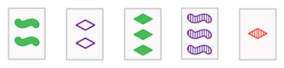

[1 2 4]


In [5]:
num_cards=5
_ = setgame.init_state(num_cards=num_cards, shuffle=False)
hand = setgame.state.dealt_cards
fig, axarr = plt.subplots(1, len(hand), figsize=(len(hand)*1,1))
pi = np.random.choice(range(len(hand)), size=len(hand), replace=False)
for i in range(len(hand)):
    card = hand[pi[i]]
    axarr[i].imshow(setgame.image_of_card(card[0], card[1]))
    axarr[i].axis('off')
plt.show()
print(np.sort(np.argsort(pi)[0:3]))


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from sklearn.model_selection import train_test_split

class SetEmbedder():
    def __init__(self, ff_dim1=128, ff_dim2=32):
        img_input = layers.Input(shape=(70, 50, 4))
        x = layers.Conv2D(32, (5, 5), activation='relu')(img_input)
        x = layers.MaxPooling2D((4,4))(x)
        x = layers.Conv2D(32, (5, 5), activation='relu')(x)
        x = layers.MaxPooling2D((4,4))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(ff_dim1, activation='relu')(x)
        x = layers.Dense(ff_dim2, activation='tanh')(x)
        outputs = layers.Dense(12, activation='sigmoid')(x)
        self.model = Model(inputs=img_input, outputs=outputs)
        self.embed = Model(self.model.input, self.model.layers[7].output)
        self.model.summary()
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        self.model_initial_weights = self.model.get_weights()

    def train(self, X_train, y_train, epochs=2):
        self.model.set_weights(self.model_initial_weights)
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

    def predict(self, X_test):
        out = self.model.predict(X_test, verbose=0)
        return out

    def embed(self, X_test):
        out = self.embed(X_test, verbose=0)
        return out

In [7]:
def convert_to_binary(attrs):
    color = {'red':[1,0,0], 'green':[0,1,0], 'purple':[0,0,1]}
    pattern = {'empty':[1,0,0], 'striped':[0,1,0], 'solid':[0,0,1]}
    shape = {'diamond':[1,0,0], 'oval':[0,1,0], 'squiggle':[0,0,1]}
    number = {'one':[1,0,0], 'two':[0,1,0], 'three':[0,0,1]}
    binary_attrs = number[attrs[0]] + color[attrs[1]] + pattern[attrs[2]] + shape[attrs[3]]
    return binary_attrs

n = 1000
X = np.empty((n, 70, 50, 4), dtype=np.float32)
y = np.empty((n, 12), dtype=int)

card_coord = [(i,j) for i in np.arange(9) for j in np.arange(9)]
for i in np.arange(n):
    c = np.random.choice(np.arange(81), size=1)[0]
    (row, col) = card_coord[c]
    attrs = setgame.attributes_of_card(row, col)
    binary_attrs = convert_to_binary(attrs)
    X[i] = setgame.image_of_card(row, col)
    y[i] = binary_attrs


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
cnn = SetEmbedder(ff_dim1=64, ff_dim2=64)
cnn.train(X_train, y_train, epochs=15)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 70, 50, 4)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 66, 46, 32)        3232      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 7, 32)         25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 96)                0   

In [38]:
for i in range(5):
    j = np.random.choice(range(X_test.shape[0]))
    pred = np.round(cnn.predict(X_test[j:(j+1)]))[0]
    pred = [int(pred[b]) for b in range(len(pred))]
    print(list(pred))
    print(list(y_test[j:(j+1)][0]))
    print('\n')

[1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]
[1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]


[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]


[0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]
[0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]


[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]


[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]
[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]




In [10]:
def create_set_dataset(num_cards, num_seqs):

    vocab_size = 81
    setgame = SetGame()
    dim = len(cnn.embed(np.expand_dims(setgame.image_of_card(0, 0), axis=0)).numpy().squeeze())

    # generate random features for each object
    card_images = np.zeros((9, 9, dim))
    for i in range(9):
        for j in range(9):  
            card_images[i,j] = cnn.embed(np.expand_dims(setgame.image_of_card(i, j), axis=0)).numpy().squeeze()
            
    object_seqs = np.zeros((num_seqs, num_cards, dim))
    card_seqs = np.zeros((num_seqs, num_cards, 2), dtype=int)
    label_seqs = np.zeros((num_seqs, num_cards), dtype=int)

    for s in range(num_seqs):
        _ = setgame.init_state(num_cards=num_cards, shuffle=False)
        hand = setgame.state.dealt_cards
        pi = np.random.choice(range(len(hand)), size=len(hand), replace=False)
        for i in range(len(hand)):
            card = hand[pi[i]]
            object_seqs[s, i] = card_images[card[0], card[1]]
            card_seqs[s, i] = [card[0], card[1]]

        set_cards = np.sort(np.argsort(pi)[0:3])
        labels = np.zeros(num_cards, dtype=int)
        labels[set_cards] = 1
        label_seqs[s] = labels

    # add `START_TOKEN` to beginning of labels
    START_TOKEN = 2
    start_tokens = np.array([START_TOKEN] * len(label_seqs))[np.newaxis].T
    label_seqs = np.hstack([start_tokens, label_seqs])

    return card_images, card_seqs, label_seqs, object_seqs,

In [11]:
card_images, card_seqs, label_seqs, object_seqs = create_set_dataset(num_cards=5, num_seqs=10000)
target = label_seqs[:, :-1]
labels = label_seqs[:, 1:]


In [12]:
test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, object_seqs_train, object_seqs_test, target_train, target_test, labels_train, labels_test = train_test_split(card_seqs, object_seqs, target, labels, test_size=0.2)

seqs_train, seqs_val, object_seqs_train, object_seqs_val, target_train, target_val, labels_train, labels_val = \
train_test_split(seqs_train, object_seqs_train, target_train, labels_train, test_size=val_size/(1-test_size))

source_train, source_val, source_test = object_seqs_train, object_seqs_val, object_seqs_test


In [13]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=None, name='sparse_categorical_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam()
from seq2seq_transformer import TeacherForcingAccuracy
teacher_forcing_acc_metric = TeacherForcingAccuracy(ignore_class=None)
metrics = [teacher_forcing_acc_metric]

In [92]:
def evaluate_seq2seq_model(model, source_test, target_test, labels_test, start_token, print_=False):
    
    n = len(source_test)
    seqs_length = source_test.shape[1]

    output = np.zeros(shape=(n, (seqs_length+1)), dtype=int)
    output[:,0] = start_token
    for i in range(seqs_length):
        predictions = model((source_test, output[:, :-1]), training=False)
        predictions = predictions[:, i, :]
        predicted_id = tf.argmax(predictions, axis=-1)
        output[:,i+1] = predicted_id

    elementwise_acc = (np.mean(output[:,1:] == labels_test))
    acc_per_position = [np.mean(output[:, i+1] == labels_test[:, i]) for i in range(seqs_length)]
    seq_acc = np.mean(np.all(output[:,1:]==labels_test, axis=1))


    teacher_forcing_acc = teacher_forcing_acc_metric(labels_test, model([source_test, target_test]))
    teacher_forcing_acc_metric.reset_state()

    if print_:
        print('element-wise accuracy: %.2f%%' % (100*elementwise_acc))
        print('full sequence accuracy: %.2f%%' % (100*seq_acc))
        print('teacher-forcing accuracy:  %.2f%%' % (100*teacher_forcing_acc))


    return_dict = {
        'elementwise_accuracy': elementwise_acc, 'full_sequence_accuracy': seq_acc,
        'teacher_forcing_accuracy': teacher_forcing_acc, 'acc_by_position': acc_per_position
        }

    return return_dict


def show_predictions(model, seqs_test, source_test, target_test, labels_test, start_token, print_=False):
    
    n = len(source_test)
    seqs_length = source_test.shape[1]

    output = np.zeros(shape=(n, (seqs_length+1)), dtype=int)
    output[:,0] = start_token
    for i in range(seqs_length):
        predictions = model((source_test, output[:, :-1]), training=False)
        predictions = predictions[:, i, :]
        predicted_id = tf.argmax(predictions, axis=-1)
        output[:,i+1] = predicted_id

    for s in range(np.min([10, source_test.shape[0]])):
        fig, axarr = plt.subplots(1, len(hand), figsize=(len(hand)*1,1))
        for i in range(len(hand)):
            card = seqs_train[s,i]
            axarr[i].imshow(setgame.image_of_card(card[0], card[1]))
            axarr[i].axis('off')
        plt.show()
        print('labels:', labels_test[s])
        print('output:', output[s][1:])

    elementwise_acc = (np.mean(output[:,1:] == labels_test))
    acc_per_position = [np.mean(output[:, i+1] == labels_test[:, i]) for i in range(seqs_length)]
    seq_acc = np.mean(np.all(output[:,1:]==labels_test, axis=1))


    teacher_forcing_acc = teacher_forcing_acc_metric(labels_test, model([source_test, target_test]))
    teacher_forcing_acc_metric.reset_state()

    if print_:
        print('\nelement-wise accuracy: %.2f%%' % (100*elementwise_acc))
        print('full sequence accuracy: %.2f%%' % (100*seq_acc))
        print('teacher-forcing accuracy:  %.2f%%' % (100*teacher_forcing_acc))


    return_dict = {
        'elementwise_accuracy': elementwise_acc, 'full_sequence_accuracy': seq_acc,
        'teacher_forcing_accuracy': teacher_forcing_acc, 'acc_by_position': acc_per_position
        }

    return return_dict

In [39]:
from seq2seq_abstracter_models import Transformer
transformer_model = Transformer(
    num_layers=4, num_heads=4, dff=64, 
    input_vocab='vector', target_vocab=3, output_dim=5,
    embedding_dim=64)

transformer_model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
transformer_model((object_seqs_train[:32], target_train[:32]));

transformer_model.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 2112      
 buted)                                                          
                                                                 
 target_embedder (Embedding)  multiple                 192       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  299776    
                                                       

In [40]:
train_size = 1000
X_train = source_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]
X_val = source_val, target_val
y_val = labels_val
history = transformer_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=1)

Epoch 1/20
32/32 [==============================] - 21s 143ms/step - loss: 0.8133 - teacher_forcing_accuracy: 0.5372 - val_loss: 0.6735 - val_teacher_forcing_accuracy: 0.6000
Epoch 2/20
32/32 [==============================] - 3s 88ms/step - loss: 0.6840 - teacher_forcing_accuracy: 0.5804 - val_loss: 0.6668 - val_teacher_forcing_accuracy: 0.6000
Epoch 3/20
32/32 [==============================] - 3s 82ms/step - loss: 0.6373 - teacher_forcing_accuracy: 0.6380 - val_loss: 0.5831 - val_teacher_forcing_accuracy: 0.6834
Epoch 4/20
32/32 [==============================] - 3s 82ms/step - loss: 0.5656 - teacher_forcing_accuracy: 0.6846 - val_loss: 0.5050 - val_teacher_forcing_accuracy: 0.7206
Epoch 5/20
32/32 [==============================] - 2s 73ms/step - loss: 0.5104 - teacher_forcing_accuracy: 0.7058 - val_loss: 0.5057 - val_teacher_forcing_accuracy: 0.6698
Epoch 6/20
32/32 [==============================] - 2s 76ms/step - loss: 0.5068 - teacher_forcing_accuracy: 0.7020 - val_loss: 0.4705

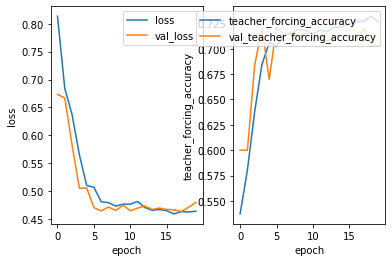

In [41]:
utils.plot_history(history, ('loss', 'teacher_forcing_accuracy'));

In [44]:
eval_dict = evaluate_seq2seq_model(transformer_model, object_seqs_train[:train_size], target_train[:train_size], labels_train[:train_size], start_token=2, print_=True)

element-wise accuracy: 52.80%
full sequence accuracy: 9.80%
teacher-forcing accuracy:  71.10%


In [86]:
from seq2seq_abstracter_models import Seq2SeqRelationalAbstracter
abstractor_model = Seq2SeqRelationalAbstracter(
    num_layers=2, num_heads=4, dff=64, 
    input_vocab='vector', target_vocab=3, output_dim=5,
    embedding_dim=64)

abstractor_model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
abstractor_model((object_seqs_train[:32], target_train[:32]));

abstractor_model.summary()

Model: "seq2seq_relational_abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 2112      
 buted)                                                          
                                                                 
 target_embedder (Embedding)  multiple                 192       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  149888    
                                     

In [87]:
train_size = 1000
X_train = source_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]
X_val = source_val, target_val
y_val = labels_val
history = abstractor_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, verbose=1)

Epoch 1/30
32/32 [==============================] - 16s 96ms/step - loss: 0.7218 - teacher_forcing_accuracy: 0.5964 - val_loss: 0.6193 - val_teacher_forcing_accuracy: 0.6434
Epoch 2/30
32/32 [==============================] - 2s 56ms/step - loss: 0.6028 - teacher_forcing_accuracy: 0.6704 - val_loss: 0.5667 - val_teacher_forcing_accuracy: 0.7176
Epoch 3/30
32/32 [==============================] - 2s 54ms/step - loss: 0.5536 - teacher_forcing_accuracy: 0.7072 - val_loss: 0.4872 - val_teacher_forcing_accuracy: 0.7206
Epoch 4/30
32/32 [==============================] - 2s 63ms/step - loss: 0.5174 - teacher_forcing_accuracy: 0.6940 - val_loss: 0.4793 - val_teacher_forcing_accuracy: 0.7130
Epoch 5/30
32/32 [==============================] - 2s 57ms/step - loss: 0.4873 - teacher_forcing_accuracy: 0.7056 - val_loss: 0.4650 - val_teacher_forcing_accuracy: 0.7162
Epoch 6/30
32/32 [==============================] - 2s 56ms/step - loss: 0.4796 - teacher_forcing_accuracy: 0.7070 - val_loss: 0.4698 

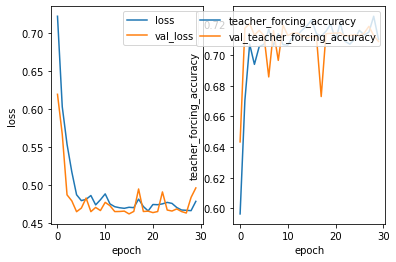

In [88]:
utils.plot_history(history, ('loss', 'teacher_forcing_accuracy'));

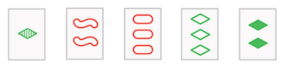

labels: [1 0 0 1 1]
output: [1 1 1 0 0]


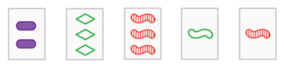

labels: [1 1 0 0 1]
output: [1 1 1 0 0]


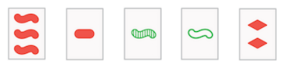

labels: [1 1 0 0 1]
output: [1 1 1 0 0]


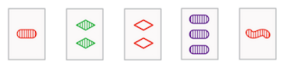

labels: [0 1 0 1 1]
output: [1 1 0 1 0]


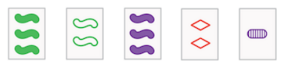

labels: [1 0 0 1 1]
output: [1 1 0 1 0]


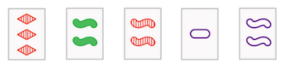

labels: [1 1 0 1 0]
output: [1 1 0 1 0]


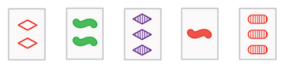

labels: [1 0 0 1 1]
output: [1 1 1 0 0]


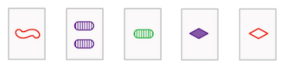

labels: [1 0 1 1 0]
output: [1 1 0 1 0]


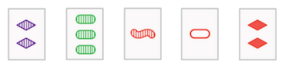

labels: [1 1 1 0 0]
output: [1 1 0 1 0]


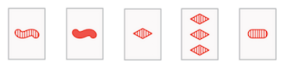

labels: [1 0 1 0 1]
output: [1 1 0 1 0]

element-wise accuracy: 51.20%
full sequence accuracy: 10.00%
teacher-forcing accuracy:  70.40%


In [93]:
eval_dict = show_predictions(transformer_model, seqs_train[0:50], object_seqs_train[0:50], target_train[0:50], labels_train[0:50], start_token=2, print_=True)